## Importing modules and data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, \
    precision_score, roc_auc_score
from sklearn.model_selection import cross_val_score



In [2]:
INPUT_PATH = 'hand_gesture_data'
features = ['vlhx', 'vlhy', 'vlhz', 'vrhx', 'vrhy', 'vrhz', 'vlwx', 'vlwy', 'vlwz', 
            'vrwx', 'vrwy', 'vrwz', 'alhx', 'alhy', 'alhz', 'arhx', 'arhy', 'arhz', 
            'alwx', 'alwy', 'alwz', 'arwx', 'arwy', 'arwz', 
            'vlh', 'vrh', 'vlw', 'vrw', 'alh', 'arh', 'alw', 'arw']

In [3]:
def join_raw_va3(data_raw, data_va3, testData=False):
    # redundant column in both
    data_raw = data_raw.drop('phase', axis=1) if not testData else data_raw.drop(['phase', 'timestamp'], axis=1)
    
    # add column names for the processed data (as it didn't have)
    data_va3.columns = features + ['Phase'] if not testData else features
    
    # outer join merge of the 2 datas
    final_data = pd.concat([data_raw.iloc[4:].reset_index(drop=True), data_va3], axis=1)
    
    return final_data


In [4]:
a1_raw = pd.read_csv(INPUT_PATH + '/a1_raw.csv')
a1_va3 = pd.read_csv(INPUT_PATH + '/a1_va3.csv')

a1 = join_raw_va3(a1_raw, a1_va3)

In [5]:
a1.columns

Index(['lhx', 'lhy', 'lhz', 'rhx', 'rhy', 'rhz', 'hx', 'hy', 'hz', 'sx', 'sy',
       'sz', 'lwx', 'lwy', 'lwz', 'rwx', 'rwy', 'rwz', 'timestamp', 'vlhx',
       'vlhy', 'vlhz', 'vrhx', 'vrhy', 'vrhz', 'vlwx', 'vlwy', 'vlwz', 'vrwx',
       'vrwy', 'vrwz', 'alhx', 'alhy', 'alhz', 'arhx', 'arhy', 'arhz', 'alwx',
       'alwy', 'alwz', 'arwx', 'arwy', 'arwz', 'vlh', 'vrh', 'vlw', 'vrw',
       'alh', 'arh', 'alw', 'arw', 'Phase'],
      dtype='object')

## Preprocessing

### Feature Engineering

In [6]:
for col in ['', 'v', 'a']:
    for pos in 'lr':
        for coord in 'xyz':
            a1[col + pos + coord] = (a1[col + pos + 'h' + coord] + a1[col + pos + 'w' + coord])/2

In [7]:
X_ = a1.loc[:, [col + pos + coord for col in ['', 'v', 'a'] for pos in 'lr' for coord in 'xyz'] + ['vlh', 'vrh', 'alh', 'arh']]
y_ = a1['Phase']

In [ ]:
X_.columns

### Encoding and Scaling

In [8]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

encoder = LabelEncoder()
scaler = StandardScaler()

y = encoder.fit_transform(y_)
X = scaler.fit_transform(X_)

### Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1307, 22), (436, 22), (1307,), (436,))

## Checking on validation set

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)
y_pred = encoder.inverse_transform(model.predict(X_test))
y_test = encoder.inverse_transform(y_test)
y_pred_proba = model.predict_proba(X_test)

In [12]:
def plot_metrics(y_true, y_pred, y_pred_proba):
    # Show metrics like F1 score precision etc
    print(f'Accuracy: {accuracy_score(y_true, y_pred)*100:.4f}%')

    print(f'ROC-AUC score: {roc_auc_score(y_true, y_pred_proba, multi_class="ovr"):.4f}')
    print(classification_report(y_true, y_pred))
    
    # Plot confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    cm_list = [confusion_matrix(y_true, y_pred, normalize='true'), confusion_matrix(y_true, y_pred)]
    
    for cm, ax in zip(cm_list, axes):
        ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
        ax.grid(False)

Accuracy: 88.7615%
ROC-AUC score: 0.9720
              precision    recall  f1-score   support

           D       0.90      0.98      0.94       173
           H       0.67      0.40      0.50        10
           P       0.95      0.44      0.60        41
           R       0.94      0.69      0.80        48
           S       0.87      0.99      0.92       164

    accuracy                           0.89       436
   macro avg       0.86      0.70      0.75       436
weighted avg       0.89      0.89      0.88       436



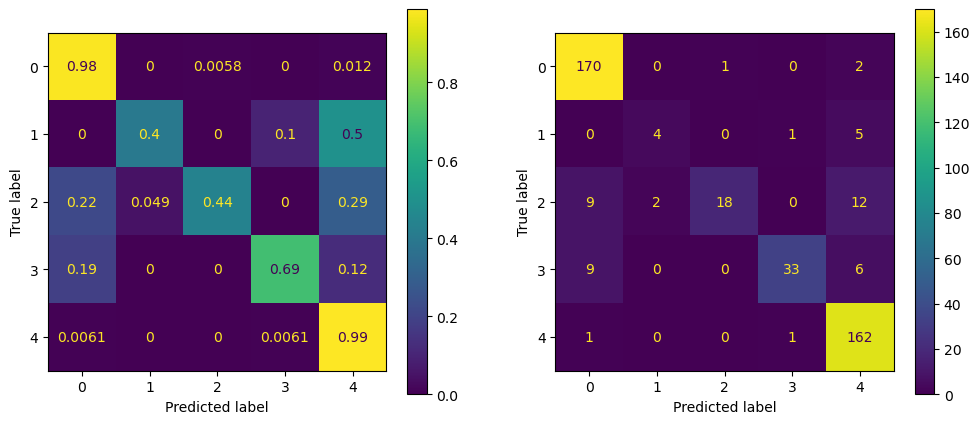

In [13]:
plot_metrics(y_test, y_pred, y_pred_proba)

## Final Test

### Importing and transforming test data

In [14]:
submission_va3 = pd.read_csv(INPUT_PATH+ '/test.csv')
submission_raw = pd.read_csv(INPUT_PATH + '/a2_raw.csv')
final_test_data = join_raw_va3(submission_raw, submission_va3, testData=True)

for col in ['', 'v', 'a']:
    for pos in 'lr':
        for coord in 'xyz':
            final_test_data[col + pos + coord] = (final_test_data[col + pos + 'h' + coord] + final_test_data[col + pos + 'w' + coord]) / 2

X_submission = scaler.transform(final_test_data.loc[:, [col + pos + coord for col in ['', 'v', 'a'] for pos in 'lr' for coord in 'xyz'] + ['vlh', 'vrh', 'alh', 'arh']])

### Running Final Model

In [24]:
from xgboost import XGBClassifier

params = {
    'booster': 'gbtree', 
    'lambda': 0.2475451263113875, 
    'alpha': 8.772147097117102e-06, 
    'subsample': 0.8931113403774391, 
    'colsample_bytree': 0.720784592951692, 
    'max_depth': 9, 
    'min_child_weight': 2, 
    'eta': 0.37168889056708165, 
    'gamma': 0.31960236227919525, 
    'grow_policy': 'depthwise'
}

model = XGBClassifier(**params)


model.fit(X, y)

y_pred_submission = encoder.inverse_transform(model.predict(X_submission))
y_pred_proba = model.predict_proba(X_submission)

### Submitting Predictions

In [25]:
def submit_prediction(y_pred, name='try'):
    submission = pd.DataFrame({'ID': range(1, y_pred.size+1), 'Phase': y_pred})
    submission.to_csv(f'submissions/{name}.csv', index=False)

In [26]:
# submit_prediction(y_pred_submission, 'hpt_xgb_69_6')